<a href="https://colab.research.google.com/github/rihemmaarefe/Link-Prediction/blob/main/Link_Prediction_Machine_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import pandas as pd
import numpy as np
import random
import networkx as nx
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [8]:
# load nodes details
with open("/content/drive/MyDrive/fb-pages-food.nodes") as f:
    fb_nodes = f.read().splitlines() 

# load edges (or links)
with open("/content/drive/MyDrive/fb-pages-food.edges") as f:
    fb_links = f.read().splitlines() 

len(fb_nodes), len(fb_links)

(621, 2102)

In [9]:
# capture nodes in 2 separate lists
node_list_1 = []
node_list_2 = []

for i in tqdm(fb_links):
  node_list_1.append(i.split(',')[0])
  node_list_2.append(i.split(',')[1])

fb_df = pd.DataFrame({'node_1': node_list_1, 'node_2': node_list_2})

100%|██████████| 2102/2102 [00:00<00:00, 459093.26it/s]


In [10]:
fb_df.head()

,node_1,node_2
0,0,276
1,0,58
2,0,132
3,0,603
4,0,398


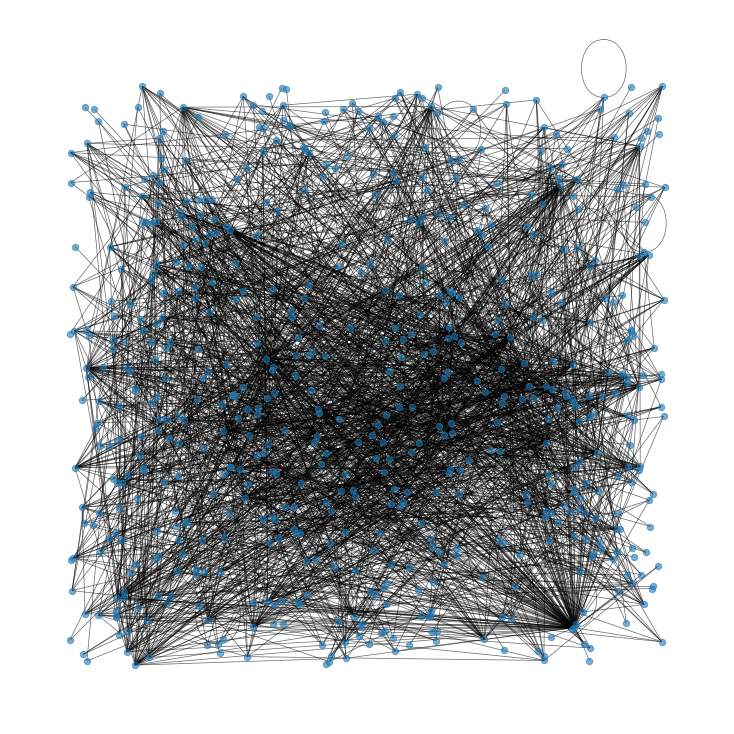

In [11]:
# create graph
G = nx.from_pandas_edgelist(fb_df, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [12]:
# combine all nodes in a list
node_list = node_list_1 + node_list_2

# remove duplicate items from the list
node_list = list(dict.fromkeys(node_list))

# build adjacency matrix
adj_G = nx.to_numpy_matrix(G, nodelist = node_list)

In [13]:
adj_G.shape

(620, 620)

In [14]:
# get unconnected node-pairs
all_unconnected_pairs = []

# traverse adjacency matrix
offset = 0
for i in tqdm(range(adj_G.shape[0])):
  for j in range(offset,adj_G.shape[1]):
    if i != j:
      if nx.shortest_path_length(G, str(i), str(j)) <=2:
        if adj_G[i,j] == 0:
          all_unconnected_pairs.append([node_list[i],node_list[j]])

  offset = offset + 1

100%|██████████| 620/620 [00:09<00:00, 62.68it/s] 


In [15]:
len(all_unconnected_pairs)

19018

In [16]:
node_1_unlinked = [i[0] for i in all_unconnected_pairs]
node_2_unlinked = [i[1] for i in all_unconnected_pairs]

data = pd.DataFrame({'node_1':node_1_unlinked, 
                     'node_2':node_2_unlinked})

# add target variable 'link'
data['link'] = 0

In [17]:
def unlinkedNodes():
  print("the unlinked nodes are : ") 
  dataUnlinked = data
  print(dataUnlinked) 

In [18]:
un = unlinkedNodes()

the unlinked nodes are : 
      node_1 node_2  link
0          0     22     0
1          0    526     0
2          0     36     0
3          0     54     0
4          0     56     0
...      ...    ...   ...
19013    606    586     0
19014    606    541     0
19015    592    573     0
19016    592    541     0
19017    573    586     0

[19018 rows x 3 columns]


In [19]:
initial_node_count = len(G.nodes)

fb_df_temp = fb_df.copy()

# empty list to store removable links
omissible_links_index = []

for i in tqdm(fb_df.index.values):
  
  # remove a node pair and build a new graph
  G_temp = nx.from_pandas_edgelist(fb_df_temp.drop(index = i), "node_1", "node_2", create_using=nx.Graph())
  
  # check there is no spliting of graph and number of nodes is same
  if (nx.number_connected_components(G_temp) == 1) and (len(G_temp.nodes) == initial_node_count):
    omissible_links_index.append(i)
    fb_df_temp = fb_df_temp.drop(index = i)

100%|██████████| 2102/2102 [00:08<00:00, 236.89it/s]


In [20]:
len(omissible_links_index)
# We have over 1483 links that we can drop from the graph. 

1483

In [21]:
# Data for Model Training
# create dataframe of removable edges
fb_df_ghost = fb_df.loc[omissible_links_index]

# add the target variable 'link' for the linked nodes
fb_df_ghost['link'] = 1

data = data.append(fb_df_ghost[['node_1', 'node_2', 'link']], ignore_index=True)

print(data)

      node_1 node_2  link
0          0     22     0
1          0    526     0
2          0     36     0
3          0     54     0
4          0     56     0
...      ...    ...   ...
20496    576    601     1
20497    584    603     1
20498    556    556     1
20499    597    601     1
20500    601    603     1

[20501 rows x 3 columns]


In [22]:
data['link'].value_counts()

0    19018
1     1483
Name: link, dtype: int64

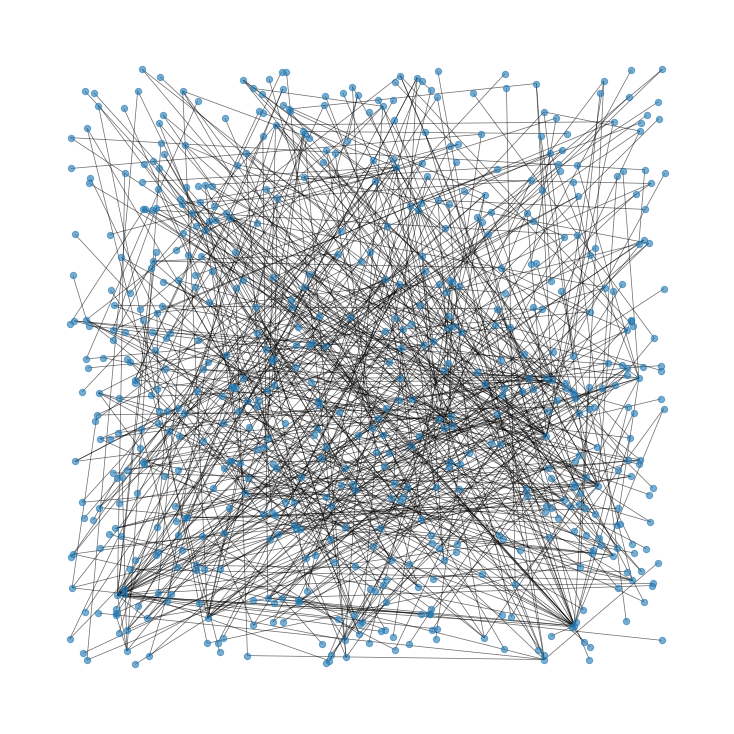

In [23]:
# Feature Extraction
# drop removable edges
fb_df_partial = fb_df.drop(index=fb_df_ghost.index.values)

# build graph
G_data = nx.from_pandas_edgelist(fb_df_partial, "node_1", "node_2", create_using=nx.Graph())

# plot graph
plt.figure(figsize=(10,10))

pos = nx.random_layout(G, seed=23)
nx.draw(G_data, with_labels=False,  pos = pos, node_size = 40, alpha = 0.6, width = 0.7)

plt.show()

In [24]:
len(G_data)

620

In [25]:
print("Given Graph is:")
print(G_data)

Given Graph is:
Graph with 620 nodes and 619 edges


In [ ]:
!pip install node2vec

Now, we will train the node2vec model on our graph (G_data):


In [27]:
from node2vec import Node2Vec

# Generate walks
node2vec = Node2Vec(G_data, dimensions=100, walk_length=16, num_walks=50)

# train node2vec model
n2w_model = node2vec.fit(window=7, min_count=1)

Computing transition probabilities:   0%|          | 0/620 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 50/50 [00:16<00:00,  2.96it/s]


In [28]:
x = [(n2w_model[str(i)]+n2w_model[str(j)]) for i,j in zip(data['node_1'], data['node_2'])]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [29]:
#Scale / normalize the values to bring them to similar range
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(x)
x = scaler.transform(x)
print(x)  #Scaled values

[[0.44708115 0.73325472 0.39459045 ... 0.31747412 0.57315335 0.28549126]
 [0.59060936 0.47289431 0.30356821 ... 0.50783432 0.55413882 0.40822808]
 [0.51294262 0.71217843 0.3571196  ... 0.48064998 0.60224479 0.42878151]
 ...
 [0.7287304  0.41025738 0.08532472 ... 0.42166835 0.43955432 0.58662137]
 [0.59756538 0.30055819 0.39344197 ... 0.75288342 0.38856815 0.3611695 ]
 [0.66011077 0.26842707 0.46268792 ... 0.70169258 0.46654714 0.36863431]]


Building our Link Prediction Model

To validate the performance of our model, we should split our data into two parts: 
- one for training the model  
- the other to test the model’s performance:



In [30]:
xtrain, xtest, ytrain, ytest = train_test_split(np.array(x), data['link'], 
                                                test_size = 0.3, 
                                                random_state = 35)

# print(xtrain)
# print(xtest)
# print(ytrain)
# print(ytest)

Let’s fit a logistic regression model first:

In [31]:
lr = LogisticRegression(class_weight="balanced")

lr = lr.fit(xtrain, ytrain)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


We will now make predictions on the test set:



In [32]:
predictions = lr.predict_proba(xtest)
predictions

array([[0.37814087, 0.62185913],
       [0.39571623, 0.60428377],
       [0.52760982, 0.47239018],
       ...,
       [0.91365501, 0.08634499],
       [0.78863536, 0.21136464],
       [0.8499817 , 0.1500183 ]])

In [ ]:
y_pred=lr.predict(xtest)
for i in range(len(y_pred)):
  if y_pred[i] == 1:
    print( "it will be linked", y_pred[i])
  else:
    print('it will not be linked', y_pred[i])

In [34]:
#Prediction
y_pred=lr.predict(xtest)
#convert into binary values
for i in range(len(y_pred)):
    if y_pred[i]>=.5:      
       y_pred[i]=1
    else:
       y_pred[i]=0
y_pred

array([1, 1, 0, ..., 0, 0, 0])

In [35]:
# We will use the AUC-ROC score to check our model’s performance
roc_auc_score(ytest, predictions[:,1])

0.7872426243507313

We get 0.80 using a logistic regression model. Let’s see if we can get a better score by using another model.

L'ets try another model:
lightGBM

In [ ]:
import lightgbm as lgbm
import pickle

train_data = lgbm.Dataset(xtrain, ytrain)
test_data = lgbm.Dataset(xtest, ytest)

# define parameters
parameters = {
    'objective': 'binary',
    'metric': 'auc',
    'is_unbalance': 'true',
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 20,
    'num_threads' : 2,
    'seed' : 76
}

# train lightGBM model
clf = lgbm.train(parameters,
                   train_data,
                   valid_sets=test_data,
                   num_boost_round=1000,
                   early_stopping_rounds=20)


the model got an impressive 0.92 AUC score on the test set. 

In [ ]:
#Prediction
res=clf.predict(xtest)
for i in range(len(res)):
  if res[i] >=.5:
    print("YES: it will be linked by", res[i])
  else:
    res[i]= 0
    print('NO: it will not be linked', res[i])
  

In [90]:
#Prediction
def pred(a,b):
  if a and b in G_data:
    y_pred = clf.predict([[a , b]])
    if y_pred >= 0.5:
      print("it can be linked by:", y_pred*100 , "%") 
    else:
        print("it cannot be linked, and by prediction it gets", y_pred, "%" ) 

In [91]:
a= 41
b= 89
pp = pred(a,b)

In [92]:
y_pred = clf.predict([[0 , 22]])
for i in y_pred:
  print(i)

0.9714166589163538
